<a href="https://colab.research.google.com/github/ShaonaSarkar/Diabetes_prediction/blob/main/finalyearfinalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow networkx numpy matplotlib tqdm pulp scikit-learn plotly

In [ ]:
import os, random, math, time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
import pulp
from sklearn.manifold import TSNE
import plotly.graph_objects as go

print("TF version:", tf.__version__)


TF version: 2.19.0


In [ ]:
# Cell 3: data generation and optional exact solver
def gen_graph(graph_type='WS', n=16, p=0.3):
    if graph_type == 'ER':
        G = nx.erdos_renyi_graph(n, p)
    elif graph_type == 'BA':
        G = nx.barabasi_albert_graph(n, max(1, int(p*n/4)))
    else:
        k = max(2, int(p*n/3))
        G = nx.watts_strogatz_graph(n, k, p/2)

    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return G

def count_conflicts(G, coloring):
    conflicts = 0
    for u,v in G.edges():
        if coloring[u] == coloring[v]:
            conflicts += 1
    return conflicts

def exact_coloring_ilp(G, max_colors=None, time_limit=30):
    nodes = list(G.nodes())
    n = len(nodes)
    if max_colors is None:
        max_colors = n
    prob = pulp.LpProblem("graph_coloring", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", (nodes, range(max_colors)), 0, 1, cat='Binary')
    y = pulp.LpVariable.dicts("y", range(max_colors), 0, 1, cat='Binary')
    prob += pulp.lpSum([y[c] for c in range(max_colors)])

    for v in nodes:
        prob += pulp.lpSum([x[v][c] for c in range(max_colors)]) == 1
    #Adjacent nodes can't share the same color
    for u,v in G.edges():
        for c in range(max_colors):
            prob += x[u][c] + x[v][c] <= 1
    #if v uses color c then the color must be active
    for v in nodes:
        for c in range(max_colors):
            prob += x[v][c] <= y[c]

    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit)
    prob.solve(solver)
    coloring = {}
    #extract the resulting coloring algo in form of a dictionary
    for v in nodes:
        for c in range(max_colors):
            if pulp.value(x[v][c]) and pulp.value(x[v][c]) > 0.5:
                coloring[v] = int(c)
                break

    used = len(set(coloring.values()))
    return coloring, used


In [ ]:
# Graph Neural Network decides how to color a graph
class SimpleGCN(tf.keras.layers.Layer):

    def __init__(self, out_dim, activation=tf.nn.relu):
        super().__init__()
        self.out_dim = out_dim #number of hidden features.
        self.activation = activation  #nonlinearity (ReLU by default).

    def build(self, input_shape):
        #Creates a Dense (fully connected) layer used in message passing.
        input_feature_dim = input_shape[-1]
        self.dense = layers.Dense(self.out_dim, use_bias=True)
        super().build(input_shape)

    def call(self, X, A):
      #Compute normalized adjacency:(This stabilizes learning by normalizing node degrees.)
        deg = tf.reduce_sum(A, axis=1, keepdims=True) + 1e-6
        D_inv = 1.0 / tf.sqrt(deg)
        D_inv_mat = tf.linalg.diag(tf.squeeze(D_inv))
        A_hat = tf.matmul(tf.matmul(D_inv_mat, A), D_inv_mat)
        #Multiply adjacency with node features (A_hat * X). Apply Dense layer + ReLU activation.
        H = tf.matmul(A_hat, X)
        return self.activation(self.dense(H))

class GNNPolicy(Model):
#Two GCN layers + one final dense output. policy_head gives logits (scores) for each possible color.
    def __init__(self, hidden=128, num_colors=6):
        super().__init__()
        self.gcn1 = SimpleGCN(hidden)
        self.gcn2 = SimpleGCN(hidden)
        self.policy_head = layers.Dense(num_colors)  # logits per node

    def call(self, X, A):
    #Sequentially passes data through two GCN layers and outputs per-node color-logits.
        h = self.gcn1(X, A)
        h = self.gcn2(h, A)
        logits = self.policy_head(h)  # (n, num_colors)
        return logits

In [ ]:
# Reinforcement Learning. action sampling and reward.Imports tensorflow_probability to sample from distributions.
import tensorflow_probability as tfp
tfd = tfp.distributions

def build_node_features(G, max_nodes):
#Create a degree feature per node, normalized.
    n = G.number_of_nodes()
    deg = np.array([d for _,d in G.degree()], dtype=np.float32)
    deg = deg / (deg.max()+1e-6)
    #Each node feature = [degree, one-hot(node ID)].
    id_onehot = np.eye(n, dtype=np.float32)
    feat = np.concatenate([deg.reshape(n,1), id_onehot], axis=1)

    # Pad features to a fixed size
    feature_dim = 1 + max_nodes
    padded_feat = np.zeros((max_nodes, feature_dim), dtype=np.float32)
    # Copy existing features, handling potential size mismatches for smaller graphs
    current_feature_dim = feat.shape[1]
    copy_width = min(current_feature_dim, feature_dim)
    padded_feat[:n, :copy_width] = feat[:, :copy_width]

    return padded_feat  # shape (max_nodes, 1+max_nodes)

def sample_actions(logits):
    # logits: (n, K) tensor
    dist = tfd.Categorical(logits=logits)
    actions = dist.sample()
    logp_per_node = dist.log_prob(actions) # logp per node (n,) tensor
    return actions, logp_per_node  # return actions and log-prob per node

def compute_reward(G, coloring, color_penalty=0.5):
    conflicts = count_conflicts(G, coloring)
    used_colors = len(set(coloring.values()))
    # reward: prefer zero conflicts and fewer colors
    reward = -conflicts - color_penalty * (used_colors - 1)
    return reward

In [ ]:
# improved hybrid correction
def hybrid_correction(G, pred_colors):
    # Use the input pred_colors dictionary directly as the initial coloring
    coloring = dict(pred_colors) # Create a copy to avoid modifying the original input
    changed = True
    while True:
        conflicts = [(u,v) for u,v in G.edges() if coloring[u] == coloring[v]]
        if not conflicts:
            break
        # pick node with most conflicts (tie-breaker: higher degree)
        node_conflicts = {}
        for u,v in conflicts:
            node_conflicts[u] = node_conflicts.get(u,0)+1
            node_conflicts[v] = node_conflicts.get(v,0)+1
        # Ensure the node selected is actually in the graph's nodes and has conflicts
        conflicting_nodes = list(node_conflicts.keys())
        if not conflicting_nodes: # Should not happen if conflicts list is not empty, but for safety
            break
        # Find the node with the maximum conflicts among the conflicting nodes
        node = max(conflicting_nodes, key=lambda n: (node_conflicts[n], G.degree(n)))

        used = {coloring[nbr] for nbr in G.neighbors(node) if nbr in coloring}
        # try reuse smallest available color
        # Find the maximum color used by the node's neighbors, defaulting to -1 if no neighbors or no colors assigned yet
        max_neighbor_color = max([-1] + [coloring[nbr] for nbr in G.neighbors(node) if nbr in coloring])

        assigned_new_color = False
        # Try to assign the smallest available color starting from 0 up to one more than the max neighbor color
        for c in range(max_neighbor_color + 2): # Check up to max_neighbor_color + 1
             if c not in used:
                coloring[node] = c
                assigned_new_color = True
                break

        # If no smaller color is available, assign a new color one greater than the maximum current color used in the *entire* coloring
        if not assigned_new_color:
             max_current_color = max([-1] + list(coloring.values()))
             coloring[node] = max_current_color + 1

    return coloring

 14%|█▍        | 101/700 [00:14<01:22,  7.24it/s]

Episode 100: reward=-3.500, baseline=-1.346


 29%|██▉       | 203/700 [00:20<00:26, 18.56it/s]

Episode 200: reward=-2.500, baseline=-1.873


 43%|████▎     | 302/700 [00:26<00:27, 14.28it/s]

Episode 300: reward=-2.500, baseline=-1.960


 57%|█████▋    | 402/700 [00:32<00:15, 18.93it/s]

Episode 400: reward=-2.500, baseline=-2.019


 72%|███████▏  | 502/700 [00:38<00:13, 14.99it/s]

Episode 500: reward=-1.500, baseline=-1.934


 86%|████████▌ | 602/700 [00:44<00:05, 18.05it/s]

Episode 600: reward=-1.000, baseline=-1.712


100%|██████████| 700/700 [00:49<00:00, 14.05it/s]


Episode 700: reward=-1.000, baseline=-1.379


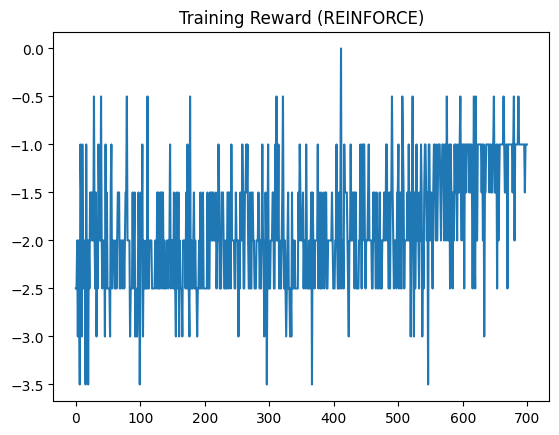

In [ ]:
# training
def train_agent(episodes=800, num_nodes=16, num_colors=6, lr=1e-3): # Changed num_nodes to 16
    agent = GNNPolicy(hidden=128, num_colors=num_colors)
    optimizer = tf.keras.optimizers.Adam(lr)
    baseline = 0.0
    gamma = 0.99
    rewards_history = []
    max_nodes = num_nodes # Use num_nodes as the max for padding
    for ep in tqdm(range(episodes)):
        G = gen_graph(random.choice(['ER','BA','WS']), n=random.randint(4, num_nodes), p=random.uniform(0.2,0.6)) # Vary number of nodes
        feat = build_node_features(G, max_nodes)  # (max_nodes, feat_dim)
        A = nx.to_numpy_array(G).astype(np.float32)

        # Pad adjacency matrix as well
        padded_A = np.zeros((max_nodes, max_nodes), dtype=np.float32)
        padded_A[:A.shape[0], :A.shape[1]] = A

        # Convert numpy arrays to tensors before passing to the agent
        feat_tensor = tf.convert_to_tensor(feat, dtype=tf.float32)
        A_tensor = tf.convert_to_tensor(padded_A, dtype=tf.float32)

        with tf.GradientTape() as tape:
            logits = agent(feat_tensor, A_tensor)  # (max_nodes, K)
            # Mask logits for nodes that don't exist in the current graph
            num_nodes_current_graph = G.number_of_nodes()
            mask = tf.sequence_mask(num_nodes_current_graph, maxlen=max_nodes, dtype=tf.float32)
            mask = tf.expand_dims(mask, axis=-1) # Shape (max_nodes, 1)
            logits = logits * mask + (1 - mask) * -1e9 # Apply mask to logits

            actions, logp_per_node = sample_actions(logits)  # actions (max_nodes,), logp per node (max_nodes,)

            # Create coloring dictionary for all nodes in the graph G
            actions_np = actions.numpy()
            coloring_dict = {node: actions_np[node] for node in G.nodes()}

            reward = compute_reward(G, coloring_dict)
            # correction step: perform hybrid correction and recompute reward
            corrected = hybrid_correction(G, coloring_dict)
            reward_corr = compute_reward(G, corrected)
            # We use reward_corr to encourage correctable policies but keep raw conflicts too
            total_reward = reward_corr

            # REINFORCE loss = - (R - baseline) * log_prob
            # Ensure total_reward is a float tensor for gradient calculation
            total_reward_tensor = tf.cast(total_reward, dtype=tf.float32)
            # Mask log probabilities for nodes that don't exist and then sum
            mask_bool = tf.range(max_nodes) < num_nodes_current_graph
            logp_masked_sum = tf.reduce_sum(tf.boolean_mask(logp_per_node, mask_bool))

            loss = - (total_reward_tensor - baseline) * logp_masked_sum

        grads = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(grads, agent.trainable_variables))
        # update baseline (simple running average)
        baseline = 0.99 * baseline + 0.01 * total_reward
        rewards_history.append(total_reward)
        if (ep+1) % 100 == 0:
            print(f"Episode {ep+1}: reward={total_reward:.3f}, baseline={baseline:.3f}")
    return agent, rewards_history

# Run training (adjust episodes depending on time)
agent, rewards = train_agent(episodes=700, num_nodes=16, num_colors=6, lr=1e-3) # Changed num_nodes to 16
plt.plot(rewards)
plt.title("Training Reward (REINFORCE)")
plt.show()

In [ ]:
# Cell 8: evaluation
def evaluate(agent, graphs, num_colors=6):
    results = []
    max_nodes_eval = max([g.number_of_nodes() for g in graphs]) # Determine max_nodes in the test set
    # Or use the max_nodes from training if applicable: max_nodes_eval = 14 # Assuming training used num_nodes=14
    max_nodes_eval = 16 # Test graphs are generated with n=16
    for G in graphs:
        # Pass max_nodes_eval to build_node_features
        feat = build_node_features(G, max_nodes_eval)
        # Need to pad A here as well, similar to training
        max_nodes = max_nodes_eval # Use max_nodes_eval for padding A
        A = nx.to_numpy_array(G).astype(np.float32)
        padded_A = np.zeros((max_nodes, max_nodes), dtype=np.float32)
        padded_A[:A.shape[0], :A.shape[1]] = A
        A_tensor = tf.convert_to_tensor(padded_A, dtype=tf.float32)
        feat_tensor = tf.convert_to_tensor(feat, dtype=tf.float32)

        logits = agent(feat_tensor, A_tensor)
        # Get actions for actual nodes in the graph
        # actions = tf.argmax(logits[:num_nodes_current_graph, :], axis=1).numpy() # This line is not needed anymore
        actions_padded = tf.argmax(logits, axis=1).numpy() # Get actions for all padded nodes

        # Create coloring dictionary for hybrid_correction and compute_reward
        # Map actual graph nodes to their corresponding actions from the padded tensor
        coloring_dict = {node: actions_padded[node] for node in G.nodes()}

        corrected = hybrid_correction(G, coloring_dict)
        greedy = nx.coloring.greedy_color(G, strategy="largest_first")
        # dsatur available via nx.algorithms.coloring.greedy_color strategy 'DSATUR' in newer versions (else keep greedy)
        try:
            dsatur = nx.coloring.greedy_color(G, strategy="DSATUR")
        except:
            dsatur = greedy

        # Ensure colorings are dictionaries for compute_reward
        corrected_dict = dict(corrected)
        greedy_dict = dict(greedy)
        dsatur_dict = dict(dsatur)

        r_ai = compute_reward(G, corrected_dict)
        r_greedy = compute_reward(G, greedy_dict)
        r_dsatur = compute_reward(G, dsatur_dict)

        # Get used colors from dictionaries
        used_colors_ai = len(set(corrected_dict.values()))
        used_colors_greedy = len(set(greedy_dict.values()))
        used_colors_dsatur = len(set(dsatur_dict.values()))

        results.append((r_ai, r_greedy, r_dsatur, used_colors_ai, used_colors_greedy, used_colors_dsatur))
    return results

# build a test set
test_graphs = [gen_graph(random.choice(['ER','BA','WS']), n=16, p=random.uniform(0.2,0.6)) for _ in range(50)]
# evaluate
res = evaluate(agent, test_graphs)
res_arr = np.array(res)
print("Avg reward AI:", res_arr[:,0].mean(), "Greedy:", res_arr[:,1].mean(), "DSATUR:", res_arr[:,2].mean())
print("Avg colors AI:", res_arr[:,3].mean(), "Greedy:", res_arr[:,4].mean(), "DSATUR:", res_arr[:,5].mean())

Avg reward AI: -1.31 Greedy: -1.12 DSATUR: -0.99
Avg colors AI: 3.62 Greedy: 3.24 DSATUR: 2.98


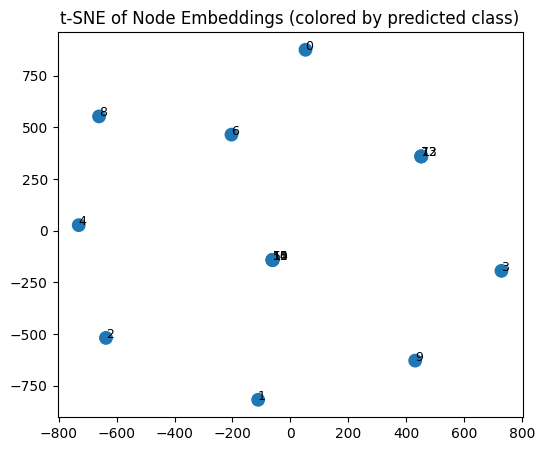

In [ ]:
# Cell 9: t-SNE embedding visualization for one graph
G = test_graphs[0]
max_nodes_viz = 16 # Use the same max_nodes as training and evaluation
feat = build_node_features(G, max_nodes_viz)
A = nx.to_numpy_array(G).astype(np.float32)
# Need to pad A here as well for consistency with the model input
padded_A = np.zeros((max_nodes_viz, max_nodes_viz), dtype=np.float32)
padded_A[:A.shape[0], :A.shape[1]] = A

# Convert numpy arrays to tensors before passing to the agent
feat_tensor = tf.convert_to_tensor(feat, dtype=tf.float32)
A_tensor = tf.convert_to_tensor(padded_A, dtype=tf.float32)

# get intermediate embeddings from agent.gcn2.dense outputs by running the layers manually
# Need to pass padded features and adjacency to the GCN layers
h1 = agent.gcn1(feat_tensor, A_tensor)
h2 = agent.gcn2(h1, A_tensor)
emb = h2.numpy()[:G.number_of_nodes(), :]  # Get embeddings for actual nodes

# Calculate perplexity based on the number of nodes
n_samples = G.number_of_nodes()
perplexity_val = min(30, max(5, n_samples - 1)) # perplexity must be less than n_samples, and typically between 5 and 50

tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_val).fit_transform(emb)

# Get predicted colors for actual nodes
logits = agent(feat_tensor, A_tensor)
colors_padded = tf.argmax(logits, axis=1).numpy()
colors = colors_padded[:G.number_of_nodes()]

plt.figure(figsize=(6,5))
plt.scatter(tsne[:,0], tsne[:,1], c=colors, cmap='tab10', s=80)
# Label actual nodes
for i, node in enumerate(G.nodes()):
    plt.text(tsne[i,0]+0.01,tsne[i,1]+0.01,str(node), fontsize=9)
plt.title("t-SNE of Node Embeddings (colored by predicted class)")
plt.show()

In [ ]:
# Cell 10: plotly interactive
def plotly_graph(G, coloring, title="Graph"):
    pos = nx.spring_layout(G, seed=1)
    edge_x, edge_y = [], []
    for u,v in G.edges():
        x0,y0 = pos[u]; x1,y1 = pos[v]
        edge_x += [x0,x1,None]; edge_y += [y0,y1,None]
    edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1,color='#888'), hoverinfo='none')
    node_x=[]; node_y=[]; node_color=[]
    for node in G.nodes():
        x,y = pos[node]; node_x.append(x); node_y.append(y)
        node_color.append(coloring[node])
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=list(G.nodes()), textposition='top center',
                            marker=dict(size=20, color=node_color, colorscale='Viridis', showscale=True))
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(title_text=title, showlegend=False)
    fig.show()

# demo
G = test_graphs[1]
max_nodes_plotly = 16 # Use the same max_nodes as training and evaluation
feat = build_node_features(G, max_nodes_plotly)
A = nx.to_numpy_array(G).astype(np.float32)
# Need to pad A here as well for consistency with the model input
padded_A = np.zeros((max_nodes_plotly, max_nodes_plotly), dtype=np.float32)
padded_A[:A.shape[0], :A.shape[1]] = A

# Convert numpy arrays to tensors before passing to the agent
feat_tensor = tf.convert_to_tensor(feat, dtype=tf.float32)
A_tensor = tf.convert_to_tensor(padded_A, dtype=tf.float32)

pred_padded = tf.argmax(agent(feat_tensor, A_tensor).numpy(), axis=1)
# Get predictions for actual nodes in the graph
pred = {node: pred_padded.numpy()[node] for node in G.nodes()}

corr = hybrid_correction(G, pred)
plotly_graph(G, corr, title="AI + Correction coloring (interactive)")

In [ ]:
# Cell 11: save model
agent.save_weights("/content/neurocolor_agent_weights.weights.h5")
# Download or save to Drive if needed
from google.colab import files
files.download("/content/neurocolor_agent_weights.weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>